In [101]:
from pvlib.iotools import get_pvgis_hourly

import pandas as pd
import datetime
import pytz

In [102]:
location = {'latitude': 52.021111, 'longitude': 8.534722}
yearlyConsumptionHousehold = 3400
yearlyConsumptionHeatpump = 2800

In [103]:
arrays = [
    {
        'surfaceTilt': 30,
        'surfaceAzimuth': -155,
        'peakPower': 340*17/1000,
        'name': 'North-East-Facing Array'
    },
    {
        'surfaceTilt': 30,
        'surfaceAzimuth': 25,
        'peakPower': 340*8/1000,
        'name': 'South-West-Facing Array'
    }
]

In [104]:
pvPower = [None] * len(arrays)
for idx, array in enumerate(arrays):
    pvPower[idx], _, _ = get_pvgis_hourly(location['latitude'], location['longitude'],
                                            surface_tilt=array['surfaceTilt'],
                                            surface_azimuth=array['surfaceAzimuth'],
                                            peakpower=array['peakPower'],
                                            pvcalculation=True,
                                            mountingplace='building',
                                            loss=14,
                                            url="https://re.jrc.ec.europa.eu/api/v5_2/",
                                            start=2019,
                                            end=2019
                                           )

In [105]:
battery = {
    "socMax": 10240,
    # Don't discharge below 10%
    "socMin": 10240*0.10,
    "efficiency": 0.95
}

In [106]:
pvPowerCombined = sum(pvPower)
# PVGIS results have a shift after the full hour, so we shift them back to the hour
# That shift is somehow dependent on the location, but I don't yet understand how,
# that why we try to guess the shift from the first entry
shift = pvPowerCombined.index[0] - datetime.datetime(2019, 1, 1, tzinfo=pytz.utc)
pvPowerCombined = pvPowerCombined.shift(-int(shift.total_seconds()/60), freq='min')

In [107]:
hdf = pd.HDFStore('2019_data_spatial.hdf5', mode='r')
# Rescale load to our usage defined above
householdLoad = hdf.get('/NO_PV/60min/HOUSEHOLD')*yearlyConsumptionHousehold*1000/hdf.get('/NO_PV/60min/HOUSEHOLD').P_TOT.sum() + hdf.get('/NO_PV/60min/HEATPUMP')*yearlyConsumptionHeatpump*1000/hdf.get('/NO_PV/60min/HEATPUMP').P_TOT.sum()
# Add UTC timezone to allow merging the dataframe with the PVGIS dataframe
householdLoad.index = householdLoad.index.tz_localize('UTC')

In [108]:
combinedDataframe = pd.concat([pvPowerCombined, householdLoad], axis=1)
combinedDataframe.rename(columns={'P_TOT': 'householdLoad', 'P': 'PV'}, inplace=True)

In [109]:
outputDataframe = combinedDataframe[['householdLoad', 'PV']]
outputDataframe = outputDataframe.assign(selfUsage=0., batteryDischarge=0., gridFeed=0., gridUsage=0., batteryChargeLevel=0., )
outputDataframe.head()

,householdLoad,PV,selfUsage,batteryDischarge,gridFeed,gridUsage,batteryChargeLevel
2019-01-01 00:00:00+00:00,869.867054,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 01:00:00+00:00,737.934386,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 02:00:00+00:00,723.909549,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 03:00:00+00:00,730.378276,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 04:00:00+00:00,704.578084,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
for time, row in combinedDataframe.iterrows():
    PV_power = row.PV
    load = row.householdLoad
    # Get battery charge from last row
    current_row_int_index = outputDataframe.index.get_loc(time)
    battery_charge = outputDataframe['batteryChargeLevel'].iloc[current_row_int_index - 1]
    
    if (PV_power >= load):
        # Cover load from PV
        excess_power = PV_power - load
        outputDataframe.at[time, 'selfUsage'] = load
        # Distribute excess power, load battery first
        # excess_power is multiplied by battery efficiency to simulate battery losses
        if battery_charge + excess_power * battery['efficiency'] > battery['socMax']:
            # Calculate power required to fully load the battery, again with a loss
            battery_charge_power = (battery['socMax'] - battery_charge) / battery['efficiency']
            # battery is full charged now, so set battery_charge to socMax
            battery_charge = battery['socMax']
            # subtract battery_charge_power from excess_power to get grid feed in
            outputDataframe.at[time, 'gridFeed'] = excess_power - battery_charge_power
        else:
            # Use excess_power to charge the battery
            battery_charge += excess_power * battery['efficiency']

    elif (PV_power < load):
        # Use PV to partially cover load
        excess_load = load - PV_power
        outputDataframe.at[time, 'selfUsage'] = PV_power
        # Try to cover the rest of the load from the battery
        if battery_charge - excess_load < battery['socMin']:
            # reduce excess_load by power provided by the battery
            battery_discharge = battery_charge - battery['socMin']
            # cover excess load not covered by the battery from the grid
            outputDataframe.at[time, 'gridUsage'] = excess_load - battery_discharge
            # set battery charge to socMin
            battery_charge = battery['socMin']
            # output consumed power from battery
            outputDataframe.at[time, 'batteryDischarge'] = battery_discharge
        else:
            # discharge battery to cover load
            battery_charge -= excess_load
            # output consumed power from battery
            outputDataframe.at[time, 'batteryDischarge'] = excess_load
    
    # Write new battery charge to the output dataframe
    outputDataframe.at[time, 'batteryChargeLevel'] = battery_charge

In [111]:
householdConsumption = outputDataframe.householdLoad.sum()/1000
pvPower = outputDataframe.PV.sum()/1000
gridConsumption = outputDataframe.gridUsage.sum()/1000
selfUsage = outputDataframe.selfUsage.sum()/1000
batteryDischarge = outputDataframe.batteryDischarge.sum()/1000
gridUsage = outputDataframe.gridUsage.sum()/1000
gridFeed = outputDataframe.gridFeed.sum()/1000

print(f'Household consumption: {householdConsumption:.0f} kWh')
print(f'Solar power: {pvPower:.0f} kWh')
print(f'direct self usage: {selfUsage:.0f} kWh / {selfUsage*100/pvPower:.1f} % of PV generation')
print(f'battery discharge: {batteryDischarge:.0f} kWh / {batteryDischarge*100/pvPower:.1f} % of PV generation')
print(f'grid feed-in: {gridFeed:.0f} kWh / {gridFeed*100/pvPower:.1f} % of PV generation')
print()
print(f'Grid consumption: {gridConsumption:.0f} kWh / {gridConsumption*100/householdConsumption:.1f} % total consumption')

Household consumption: 6200 kWh
Solar power: 6043 kWh
direct self usage: 2037 kWh / 33.7 % of PV generation
battery discharge: 1231 kWh / 20.4 % of PV generation
grid feed-in: 2709 kWh / 44.8 % of PV generation

Grid consumption: 2932 kWh / 47.3 % total consumption


<AxesSubplot:ylabel='Battery Charge'>

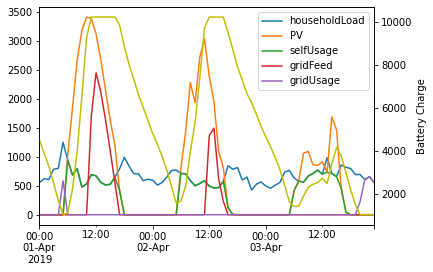

In [112]:
dateFrom = '2019-04-01'
dateUntil = '2019-04-03'
ax_power = outputDataframe[['householdLoad', 'PV', 'selfUsage', 'gridFeed', 'gridUsage']].loc[dateFrom:dateUntil].plot()

ax_battery = ax_power.twinx()
ax_battery.set_ylabel('Battery Charge')
ax_battery.spines['right'].set_position(('axes', 1.0))
outputDataframe['batteryChargeLevel'].loc[dateFrom:dateUntil].plot(ax=ax_battery, style='y-')